# CMSE 202 Project Analysis Notebook

In this notebook, we will be creating an SVM and a Logistic Regression to find how an invasive species can influence the likelihood of the arctic cod's population in the ecosystem crashing (hitting zero).

We will first create an SVM and compare the state of the arctic cod population over five years depending on the parameters of birth rate, death rate, and if the invasive species is present.

Then we will create a logistic regression with a similar goal.

Lastly, we will compare the SVM and Logistic Regression by running them on new large datasets to see which turned out to be more efficient at predicting if arctic cod populations will crash.

**Libraries**

In [1]:
# general
import ecosystem
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_lfw_people
from sklearn import metrics

# ensure reproducibility
random.seed(1)

## 1) Running an SVM with Cod & Invasive Species Data

#### No Invasive Species

First we will run 100 simulations where there is no invasive species present to see how the cod's birth and death rate affects the likelihood of extinction.

_Running Sims_

In [2]:
# No Invasive Species
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

_Plotting_

Text(0.5, 1.0, 'Cod Extinction Simulations')

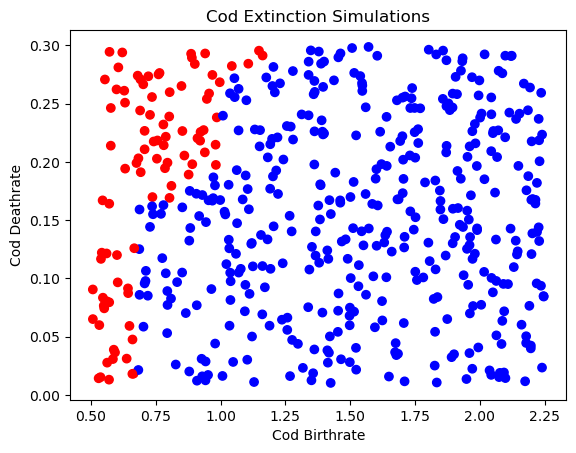

In [3]:
cod_itr = np.array(cod_itr)

cmap = np.where(cod_itr[:,4] == 1, 'red', 'blue')

plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlabel("Cod Birthrate")
plt.ylabel("Cod Deathrate")
plt.title("Cod Extinction Simulations")

The red dots represent simulations in which the cod populations hit zero, thus meaning an extinction of cod has occured.

We can see that with no invasive species, a birth rate below ~0.6 likely causes extinctions, and as death rates get higher so does the chance of extinction increase.

One nice thing about plotting is we can see that this data looks pretty linearly separable, meaning a SVM would be a good choice for analysis.

#### SVM for No Invasive Species

Let's run a SVM with our data to see how it may create a linear fit for the data.

_Separating data into features and classes_

In [4]:
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

_Using train_test_split on the data for analysis purposes_

In [5]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.25, train_size=.75)

**SVM Classification Model**

Here we will run a SVM model, and we will try different parameters for the C and gamma to try and get the best possible fit.

In [6]:
# creating a param grid to find good values for C and gamma
# For the kernel, we will only use linear since we see that linear separability is perfect for the data.
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}

# Creating a classifier and using the param_grid to find best values.
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# fit the classifier to the data
clf = clf.fit(feature_vectors, class_labels)
print(f"Best estimator is {clf.best_estimator_}")
print(f"Best parameters are {clf.best_params_}")

Best estimator is SVC(C=1000.0, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters are {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}


Let's run the clf with our test vectors to see how accurate it is.

In [7]:
pred_class = clf.predict(test_vectors)
print(f"Percentage accuracy: {sum(pred_class == test_labels) / len(test_labels)}")

Percentage accuracy: 0.96


We get an accuracy of 96%, which is quite a good start!

Now let's graph our SVM using its coefficients to make a line where it separates the data.

_Getting coefficients_

In [8]:
w1, w2 = clf.best_estimator_.coef_[0]
b = clf.best_estimator_.intercept_[0]

_Scatter plotting with entire data and SVM generated line_

Text(0.5, 1.0, 'Cod Extinction from Birth & Death Rate (No Invasive)')

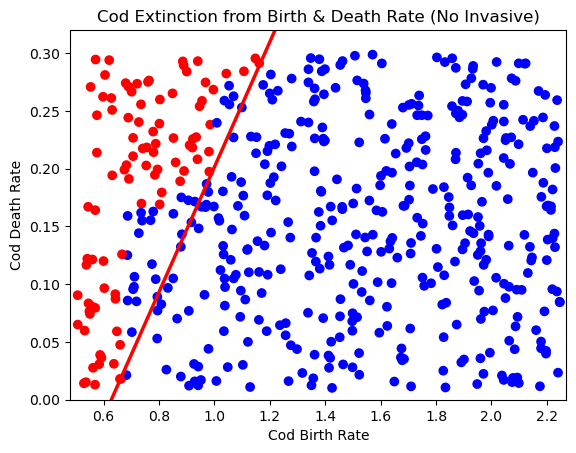

In [9]:
def point(x, w1, w2, b):
    """
    Returns a point given the x-points, weights, and intercept.

    x: The specificed point on the x-axis
    w1: The first weight of the best estimator
    w2: The second weight of the best estimator
    b: The line intercept from the best estimator
    """
    return -w1 / w2 * x - b / w2

# Graphing SVM line
line = [point(0, w1, w2, b), point(2.25, w1, w2, b)]
plt.plot([0, 2.25], line, color='red', lw=2.5)

# Plotting cod data
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlim(.48, 2.27)
plt.ylim(0, .32)
plt.xlabel("Cod Birth Rate")
plt.ylabel("Cod Death Rate")
plt.title("Cod Extinction from Birth & Death Rate (No Invasive)")

We can see the line does a decent job of separating the data, showing that a SVM is not a bad option.

However you can see a small group of blue dots between [0.6, 0.8]x and [0.05, 1.75]y that the line is unable to fit properly. Perhaps a different kind of model would help? We'll get to that in a bit!

#### With Invasive Species

Now we will repeat all the steps we did above, but this time the simulation will include the invasive species, the king crab.

_Running 500 simulations with the invasive species_

In [10]:
# Invasive Species
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(invasive=True, cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

_Plotting resulting data_

Text(0.5, 1.0, 'Cod Extinction from Birth & Death Rate (Invasive)')

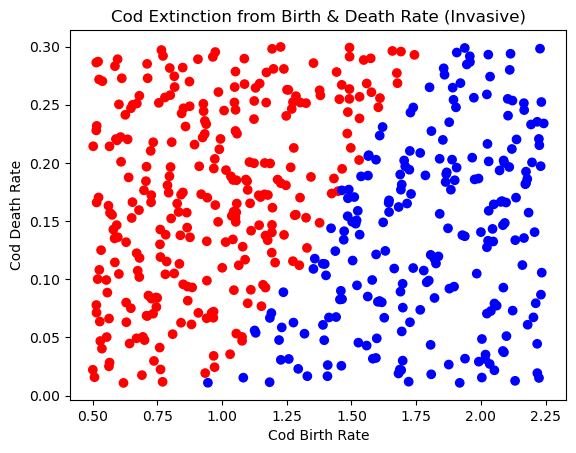

In [11]:
cod_itr = np.array(cod_itr)

cmap = np.where(cod_itr[:,4] == 1, 'red', 'blue')

plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlabel("Cod Birth Rate")
plt.ylabel("Cod Death Rate")
plt.title("Cod Extinction from Birth & Death Rate (Invasive)")

We can see from this graph that the amount of simulations where arctic cod goes extinct has increased, but the data still looks to be great for a SVM since it looks pretty linearly separable.

**SVM Classification Model, Part 2**

Once again we will run a SVM model on this new data.

_Separating data into features and classes_

In [12]:
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

_Splitting data with train_test_split for analysis purposes_

In [13]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.25, train_size=.75)

_Running the SVM on the data to find best parameters_

In [14]:
# creating a param grid to find good values for C and gamma
# For the kernel, we will only use linear since we see that linear separability is perfect for the data.
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}

# Creating a classifier and using the param_grid to find best values.
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# fit the classifier to the data
clf = clf.fit(feature_vectors, class_labels)
print(f"Best estimator is {clf.best_estimator_}")
print(f"Best parameters are {clf.best_params_}")

Best estimator is SVC(C=5000.0, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters are {'C': 5000.0, 'gamma': 0.0001, 'kernel': 'linear'}


_Testing test_vectors on the SVM_

In [15]:
pred_class = clf.predict(test_vectors)
print(f"Percentage accuracy: {sum(pred_class == test_labels) / len(test_labels)}")

Percentage accuracy: 1.0


We managed to get a 100% accuracy! While this seems pretty great, it's important to remember that the true accuracy may be lower once more tests are run. We will return to this idea at the end.

Now, let's plot our SVM line.

_Plotting data with SVM line_

Text(0.5, 1.0, 'Cod Extinction from Birth & Death Rate (Invasive)')

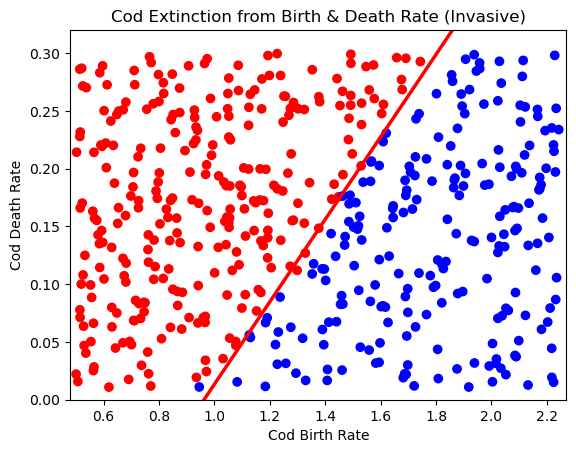

In [16]:
w1, w2 = clf.best_estimator_.coef_[0]
b = clf.best_estimator_.intercept_[0]

def point(x, w1, w2, b):
    """
    Returns a point given the x-points, weights, and intercept.

    x: The specificed point on the x-axis
    w1: The first weight of the best estimator
    w2: The second weight of the best estimator
    b: The line intercept from the best estimator
    """
    return -w1 / w2 * x - b / w2

# Graphing SVM line
inv_line = [point(0, w1, w2, b), point(2.25, w1, w2, b)]
plt.plot([0, 2.25], inv_line, color='red', lw=2.5)

# Plotting cod data
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlim(.48, 2.27)
plt.ylim(0, .32)
plt.xlabel("Cod Birth Rate")
plt.ylabel("Cod Death Rate")
plt.title("Cod Extinction from Birth & Death Rate (Invasive)")

We can see that this line is farther along the x-axis than the one from the simulations with no invasive species.

Let's combine the graphs to get a better insight into how different our SVM lines are depending on the simulation.

#### Putting Them Together

We will now run 500 simulations, with two simulations being run at a time where the only difference in their parameters is the presence of an invasive species. We will then plot this data along with our two SVM lines to see how accurate our linera separation is and how the SVM lines differ from one another.

_Running 500 simulations, 2 at a time_

In [17]:
# Both
cod_itr = []
for i in range(250): # Range is 250, since each loop runs 2 simulations
    ecosystem.reset_pops()

    # cbr = cod birth rate
    # cdr = cod death rate
    # the cbr and cdr will be the same for the two simulations
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)

    # Running simulation with no invasive species
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

    # Running simulation with invasive species
    ecosystem.reset_pops()
    ecosystem.run(invasive=True,cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

_Plotting data with both SVM lines_

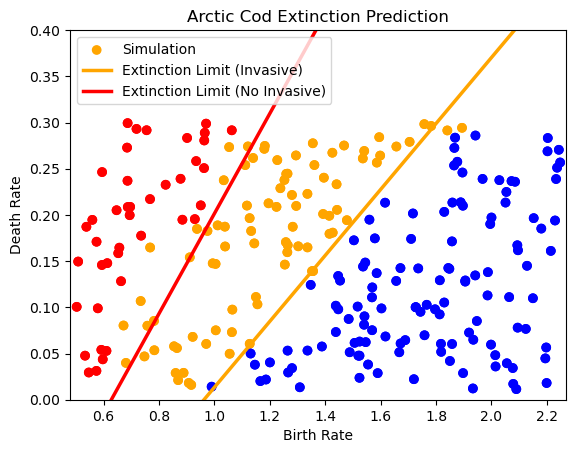

In [18]:
# Convert to np_array
cod_itr = np.array(cod_itr)

# Create a colormap for the data
cmap = []
for i in range(len(cod_itr[:,4])):
    if cod_itr[i,4] == 1 and cod_itr[i,3] == 0:
        cmap.append('red')
    elif cod_itr[i,4] == 1 and cod_itr[i,3] == 1:
        if cod_itr[i-1,4] == 1:
            cmap.append('red')
        else:
            cmap.append('orange')
    elif i % 2 == 0 and cod_itr[i+1,4] == 1:
        cmap.append('orange')
    else:
        cmap.append('blue')

# Plotting data
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)

# Plotting invasive species SVM line
plt.plot([0, 2.25], inv_line, color='orange', lw=2.5)

# Plotting no invasive species SVM line
plt.plot([0, 2.25], line, color='red', lw=2.5)

# Plot features
plt.xlim(.48, 2.27)
plt.ylim(0, .4)
plt.title("Arctic Cod Extinction Prediction")
plt.xlabel("Birth Rate")
plt.ylabel("Death Rate")
plt.legend(['Simulation', 'Extinction Limit (Invasive)', 'Extinction Limit (No Invasive)'], loc="upper left")

From these results, we can see that the extinction limit with invasive species line has a greater slope and starts farther along the x-axis. This shows how the invasive species does have a large impact on the population of cod, as if they do not reproduce fast enough, they will die in environments with invasive species as compared to that same environment where there was no invasive species.

While these results look solid, it is always a good idea to try comparing them against a different kind of model to see if you can get more accurate results.

### 2) Logistic Model Regression

We will now do the same kind of prediction, but this time instead of using an SVM we will be using a Logistic Regression with the statsmodel package.

#### No Invasive Species

Once again, we will start simulating the ecosystem with no invasive species.

_Running 500 simulations with no invasive species_

In [19]:
# No Invasive Species
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

In [20]:
# np array conversion
cod_itr = np.array(cod_itr)

# Separating the data into features and classes
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

# Splitting the data with train_test_split
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.3, train_size=.7)

We will now run a logistic regression using statsmodel.

_Logistic regression model_

In [21]:
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors)) # Have to add a constant
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.054736
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  350
Model:                          Logit   Df Residuals:                      347
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.8888
Time:                        20:26:03   Log-Likelihood:                -19.157
converged:                       True   LL-Null:                       -172.33
Covariance Type:            nonrobust   LLR p-value:                 2.999e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4183      3.345      4.310      0.000       7.862      20.975
x1           -27.9692      6

We can see a pseudo R-squared score of about 0.888, which is a decently high score- but perhaps its not as good as the SVM? Let's test it on our test data with sklearn's metrics.

_Predict with test_vectors_

In [22]:
predict = result.predict(sm.add_constant(test_vectors))
predict[predict > 0.5] = 1
predict[predict <= 0.5] = 0

_See accuracy score_

In [23]:
metrics.accuracy_score(test_labels, predict)

1.0

We get an accuracy of 100% on our test data! But of course, with higher amounts of samples this accuracy may actually be lower.

While there are many ways to visualize the logistic regression results, we decided to go with a contour map as it seemed to be the easiest to display with our data.

_Create x-vars to plug in for the contour map_

In [24]:
x1_vals = np.linspace(0.5, 2.25, 250)
x2_vals = np.linspace(0, 0.3, 250)

_Create a mesh grid to display on the contour map_

In [25]:
# Create mesh grid
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
grid = pd.DataFrame()

# Add the constant term
grid['const'] = 1 # Make sure constant term comes FIRST in the dataframe
grid['x1'] = x1_grid.ravel()
grid['x2'] = x2_grid.ravel()
grid['const'] = 1 # Have to run this again since grid['const'] kept getting assigned as NaN

# Plug in the grid x values to get the resulting y values for the contour map.
predicted_probs = result.predict(grid).values.reshape(x1_grid.shape)

Let's plot the contour map with the test vectors to get an idea of how accurate our model is.

_Plot contour map_

/tmp/ipykernel_220253/1785843623.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(test_vectors[:,0], test_vectors[:,1], c=colors, cmap='coolwarm', edgecolor='white', alpha=0.7)  # Overlay actual data points


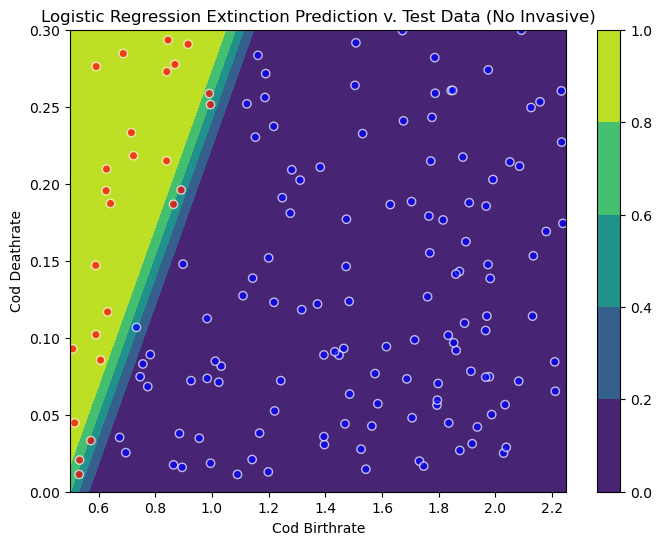

In [26]:
colors = np.where(test_labels == 1, 'red', 'blue') # Create colormap for datapoints

# Contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_grid, x2_grid, predicted_probs, levels=5)
plt.colorbar(contour)
plt.scatter(test_vectors[:,0], test_vectors[:,1], c=colors, cmap='coolwarm', edgecolor='white', alpha=0.7)  # Overlay actual data points

# Labels
plt.xlabel('Cod Birthrate')
plt.ylabel('Cod Deathrate')
plt.title('Logistic Regression Extinction Prediction v. Test Data (No Invasive)')
plt.show()

As we can see, all the test data seems to land to the correct part of the logistic regression's predicted area. The error area is also not too large, as there is only a little bit of error within the separation of the areas as we can see with the color bar.

#### With Invasive Species

Once again, we will run the logistic model but with an invasive species to see how they compare.

_Running 500 simulations with invasive species present_

In [27]:
# Invasive Species
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(invasive=True, cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

_Prepping variables for logistic model_

In [28]:
# Convert to np array
cod_itr = np.array(cod_itr)

# Separate data into features and classes
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

# Use train_test_split to get test and train data for analysis
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.3, train_size=.7)

_Running the logistic model_

In [29]:
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.021156
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  350
Model:                          Logit   Df Residuals:                      347
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.9695
Time:                        20:26:25   Log-Likelihood:                -7.4047
converged:                       True   LL-Null:                       -242.60
Covariance Type:            nonrobust   LLR p-value:                7.167e-103
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.3810     35.564      2.541      0.011      20.676     160.086
x1           -94.6226     37

This time our R-squared score is much higher, at ~97%. This would make sense as we saw with the invasive data when we were running our SVM model that the invasive species tends to make the data more linearly separable.

Let's see how well our logistic model did with the sklearn metrics.

_Predicting with test vector_

In [30]:
predict = result.predict(sm.add_constant(test_vectors))
predict[predict > 0.5] = 1
predict[predict <= 0.5] = 0

_Accuracy score assessment_

In [31]:
metrics.accuracy_score(test_labels, predict)

0.9933333333333333

We get a very high accuracy score of 99%! However, it isn't a perfect 100%. This means that there is at least one data point the model got wrong. We'll create another contour map and plot the test data to see!

_Set x_vals for contour plotting_

In [32]:
x1_vals = np.linspace(0.5, 2.25, 300)
x2_vals = np.linspace(0, 0.3, 300)

In [33]:
# Create mesh grid
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
grid = pd.DataFrame()

# Add the constant term
grid['const'] = 1 # Make sure constant term comes FIRST in the dataframe
grid['x1'] = x1_grid.ravel()
grid['x2'] = x2_grid.ravel()
grid['const'] = 1 # Have to run this again since grid['const'] kept getting assigned as NaN

# Plug in the grid x values to get the resulting y values for the contour map.
predicted_probs = result.predict(grid).values.reshape(x1_grid.shape)

/tmp/ipykernel_220253/4178888652.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(test_vectors[:,0], test_vectors[:,1], c=colors, cmap='coolwarm', edgecolor='white', alpha=0.7)  # Overlay actual data points


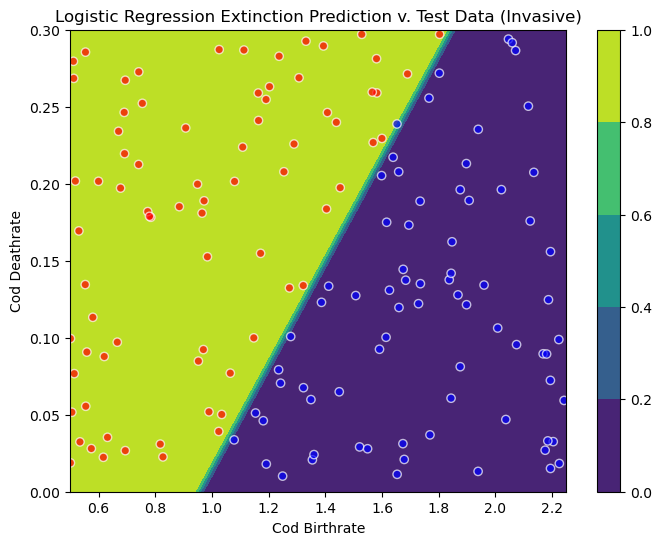

In [34]:
colors = np.where(test_labels == 1, 'red', 'blue') # Create colormap for datapoints

# Contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_grid, x2_grid, predicted_probs, levels=5)
plt.colorbar(contour)
plt.scatter(test_vectors[:,0], test_vectors[:,1], c=colors, cmap='coolwarm', edgecolor='white', alpha=0.7)  # Overlay actual data points

# Labels
plt.xlabel('Cod Birthrate')
plt.ylabel('Cod Deathrate')
plt.title('Logistic Regression Extinction Prediction v. Test Data (Invasive)')
plt.show()

The amount of error on this logistic regression is much lower, which tracks with the better linearity of invasive species being present. However we can see that there was one simulation near the top in which arctic cod actually survived, but the model predicted they would go extinct.

## 3) Comparing both predictions on a large dataset

Now that we have two different models, we can see how accurate they'll be by running a large amount of simulations and calculating their accuracy scores.

We will run 5000 simulations with an invasive species and try to predict the classes with both models.

**WARNING:** Running 5000 simulations may take a few minutes!

In [38]:
# Invasive Species
cod_itr = []
for i in range(5000):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(invasive=True, cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

In [39]:
cod_itr = np.array(cod_itr)
prediction_set = cod_itr[:,(0,1)]
true_labels = cod_itr[:,4]

In [41]:
# Testing to see how accurate it can assess if the cod pop will collapse from an invasive species.
# SVM
SVM_Pred = clf.predict(prediction_set)

# Logistic
Log_pred = result.predict(sm.add_constant(prediction_set))
# Rounding
Log_pred[Log_pred > 0.5] = 1
Log_pred[Log_pred <= 0.5] = 0

# Comparison
print(f"Out of {len(true_labels)} simulations, the Support Vector Machine correctly predicted if the arctic cod would crash in {sum(SVM_Pred == true_labels)}.")
print(f"Out of {len(true_labels)} simulations, the Logistic Regression correctly predicted if the arctic cod would crash in {sum(Log_pred == true_labels)}.")
print()
print(f"SVM Percentage: {sum(SVM_Pred == true_labels) / len(true_labels)}")
print(f"Log Percentage: {sum(Log_pred == true_labels) / len(true_labels)}")

Out of 5000 simulations, the Support Vector Machine correctly predicted if the arctic cod would crash in 4923.
Out of 5000 simulations, the Logistic Regression correctly predicted if the arctic cod would crash in 4934.

SVM Percentage: 0.9846
Log Percentage: 0.9868


**Results**

We can see both models were quite accurate, however it seems that the logistic model was slightly better at predicting if the arctic cod population would crash or not! The logistic regression does allow for a bit more flexibility for the data, since there are slight error zones within it. Therefore it makes sense that it is slightly better at predicting the likelihood of a crash.

_One last plot for fun_

/tmp/ipykernel_220253/589358699.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(prediction_set[:,0], prediction_set[:,1], c=colors, cmap='coolwarm', alpha=1, s=1)  # Overlay actual data points


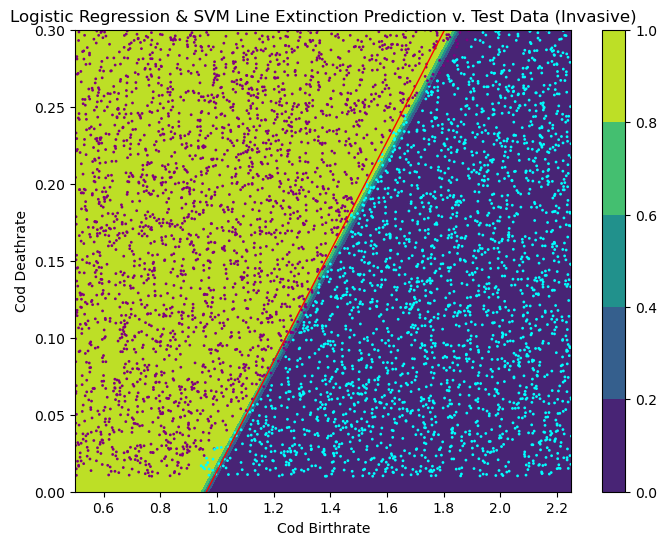

In [72]:
x1_vals = np.linspace(0.5, 2.25, 300)
x2_vals = np.linspace(0, 0.3, 300)

# Create mesh grid
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
grid = pd.DataFrame()

# Add the constant term
grid['const'] = 1 # Make sure constant term comes FIRST in the dataframe
grid['x1'] = x1_grid.ravel()
grid['x2'] = x2_grid.ravel()
grid['const'] = 1 # Have to run this again since grid['const'] kept getting assigned as NaN

# Plug in the grid x values to get the resulting y values for the contour map.
predicted_probs = result.predict(grid).values.reshape(x1_grid.shape)

colors = np.where(true_labels == 1, 'purple', 'cyan') # Create colormap for datapoints

# Contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_grid, x2_grid, predicted_probs, levels=5)
plt.colorbar(contour)
plt.scatter(prediction_set[:,0], prediction_set[:,1], c=colors, cmap='coolwarm', alpha=1, s=1)  # Overlay actual data points

# SVM Line
plt.plot([0, 2.25], inv_line, color='red', lw=1)
plt.xlim(.5, 2.25)
plt.ylim(0, .3)

# Labels
plt.xlabel('Cod Birthrate')
plt.ylabel('Cod Deathrate')
plt.title('Logistic Regression & SVM Line Extinction Prediction v. Test Data (Invasive)')
plt.show()

_Purple dots: Arctic cod went extinct_<br>
_Cyan dots: Arctic cod survived_<br>
_Red Line: SVM Line_<br>
_Color bar: Logistic Regression Contour Map_

As you can see, the way the SVM predicted the data and the logistic regression was slightly different! Though the logistic regression seems to have been ever so slightly more accurate.

Of course, there are still data points both models missed- such as the clump of cyan dots near the bottom.

## 4) Conclusion

Comparing the data, we can see that invasive species can have major impacts on ecosystems. This is because if we compare the logistic model for simulations with no invasive species with the simulations with invasive species, We can see how the extinction simulations increase massively once the invasive species is introduced!

The SVM also illustrates this point well, as we can plot both SVM lines and see how the slope for the invasive species line is greater, and it's x-intercept is farther along than the simulations with no invasive species.

Overall, through running a simulation with a compartmental model and using an SVM and Logistic Regression to see the predictability of extinction, we can conclude that invasive species can cause ecosystems to collapse if their prey are unable to reproduce at a fast enough rate, or if their natural death rate is too high.